In [ ]:
import os
import tensorflow as tf
import random as rn
os.listdir('/kaggle/input')

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, MEstimateEncoder


from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold
import optuna
from sklearn.compose import ColumnTransformer

from sklearn.base import clone
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
FILE_PATH = "/kaggle/input/playground-series-s4e2/"
TARGET = "NObeyesdad"
n_splits = 9
RANDOM_SEED = 42

In [4]:
train = pd.read_csv(os.path.join(FILE_PATH, "train.csv"))
test = pd.read_csv(os.path.join(FILE_PATH, "test.csv"))
sample_sub = pd.read_csv(os.path.join(FILE_PATH, "sample_submission.csv"))
train_org = pd.read_csv("/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv")

In [ ]:
print("Train Data")
print(f"Total number of rows: {len(train)}")
print(f"Total number of columns: {train.shape[1]}\n")

print("Test Data")
print(f"Total number of rows: {len(test)}")
print(f"Total number of columns:{test.shape[1]}")

In [ ]:
train_copy = train.rename(columns={"family_history_with_overweight":"FHWO"})
tmp = pd.DataFrame(index=train_copy.columns)
tmp['count'] = train_copy.count()
tmp['dtype'] = train_copy.dtypes
tmp['nunique'] = train_copy.nunique()
tmp['%nunique'] = (tmp['nunique']/len(train_copy))*100
tmp['%null'] = (train_copy.isnull().sum()/len(train_copy))*100
tmp['min'] = train_copy.min()
tmp['max'] = train_copy.max()
tmp

tmp.reset_index(inplace=True)
tmp = tmp.rename(columns = {"index":"Column Name"})
tmp = tmp.round(3)
print(tmp)
del tmp, train_copy

In [ ]:
tmp = pd.DataFrame(train.groupby([TARGET,'Gender'])["id"].agg('count'))
tmp.columns = ['Count']
train[TARGET].value_counts()
tmp = pd.merge(tmp,train[TARGET].value_counts(),left_index=True, right_index=True)
tmp.columns = ['gender_count','target_class_count']
tmp['%gender_count'] = tmp['gender_count']/tmp['target_class_count']
tmp["%target_class_count"] = tmp['target_class_count']/len(train) 
tmp = tmp[['gender_count','%gender_count','target_class_count','%target_class_count']]
print("Target Distribution with Gender")
tmp


In [8]:
raw_num_cols = list(train.select_dtypes("float").columns) 
raw_cat_cols = list(train.columns.drop(raw_num_cols+[TARGET]))

full_form = dict({'FAVC' : "Frequent consumption of high caloric food",
                  'FCVC' : "Frequency of consumption of vegetables",
                  'NCP' :"Number of main meal",
                  'CAEC': "Consumption of food between meals",
                  'CH2O': "Consumption of water daily",
                  'SCC':  "Calories consumption monitoring",
                  'FAF': "Physical activity frequency",
                  'TUE': "Time using technology devices",
                  'CALC': "Consumption of alcohol" ,
                  'MTRANS' : "Transportation used"})


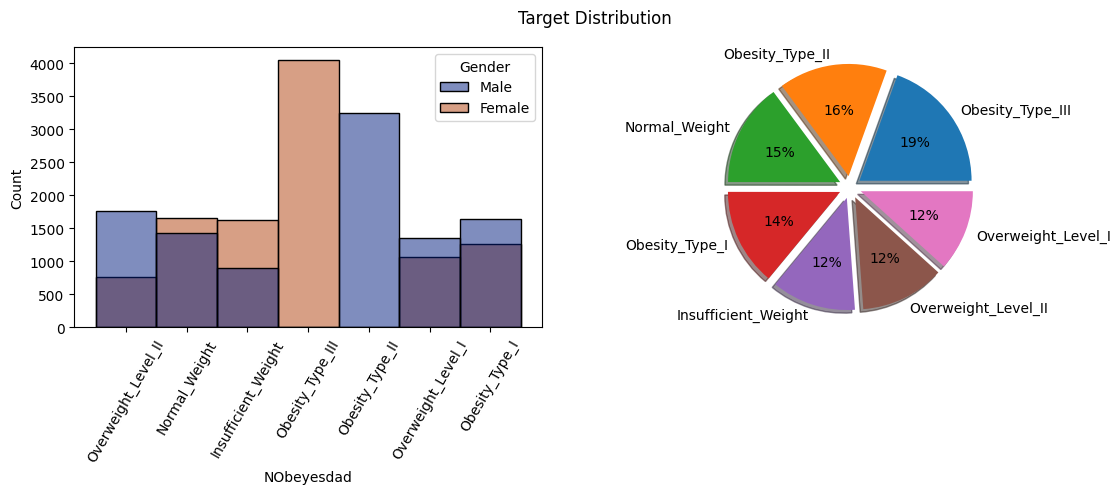

In [9]:
fig, axs = plt.subplots(1,2,figsize = (12,5))
plt.suptitle("Target Distribution")

sns.histplot(binwidth=0.5,x=TARGET,data=train,hue='Gender',palette="dark",ax=axs[0],discrete=True)
axs[0].tick_params(axis='x', rotation=60)

axs[1].pie(
        train[TARGET].value_counts(),
        shadow = True,
        explode=[.1 for i in range(train[TARGET].nunique())],
        labels = train[TARGET].value_counts().index,
        autopct='%1.f%%',
    )

plt.tight_layout()
plt.show()

In [ ]:
fig,axs = plt.subplots(len(raw_num_cols),1,figsize=(12,len(raw_num_cols)*2.5),sharex=False)
for i, col in enumerate(raw_num_cols):
    sns.violinplot(x=TARGET, y=col,hue="Gender", data=train,ax = axs[i], split=False)
    if col in full_form.keys():
        axs[i].set_ylabel(full_form[col])

plt.tight_layout()
plt.show()

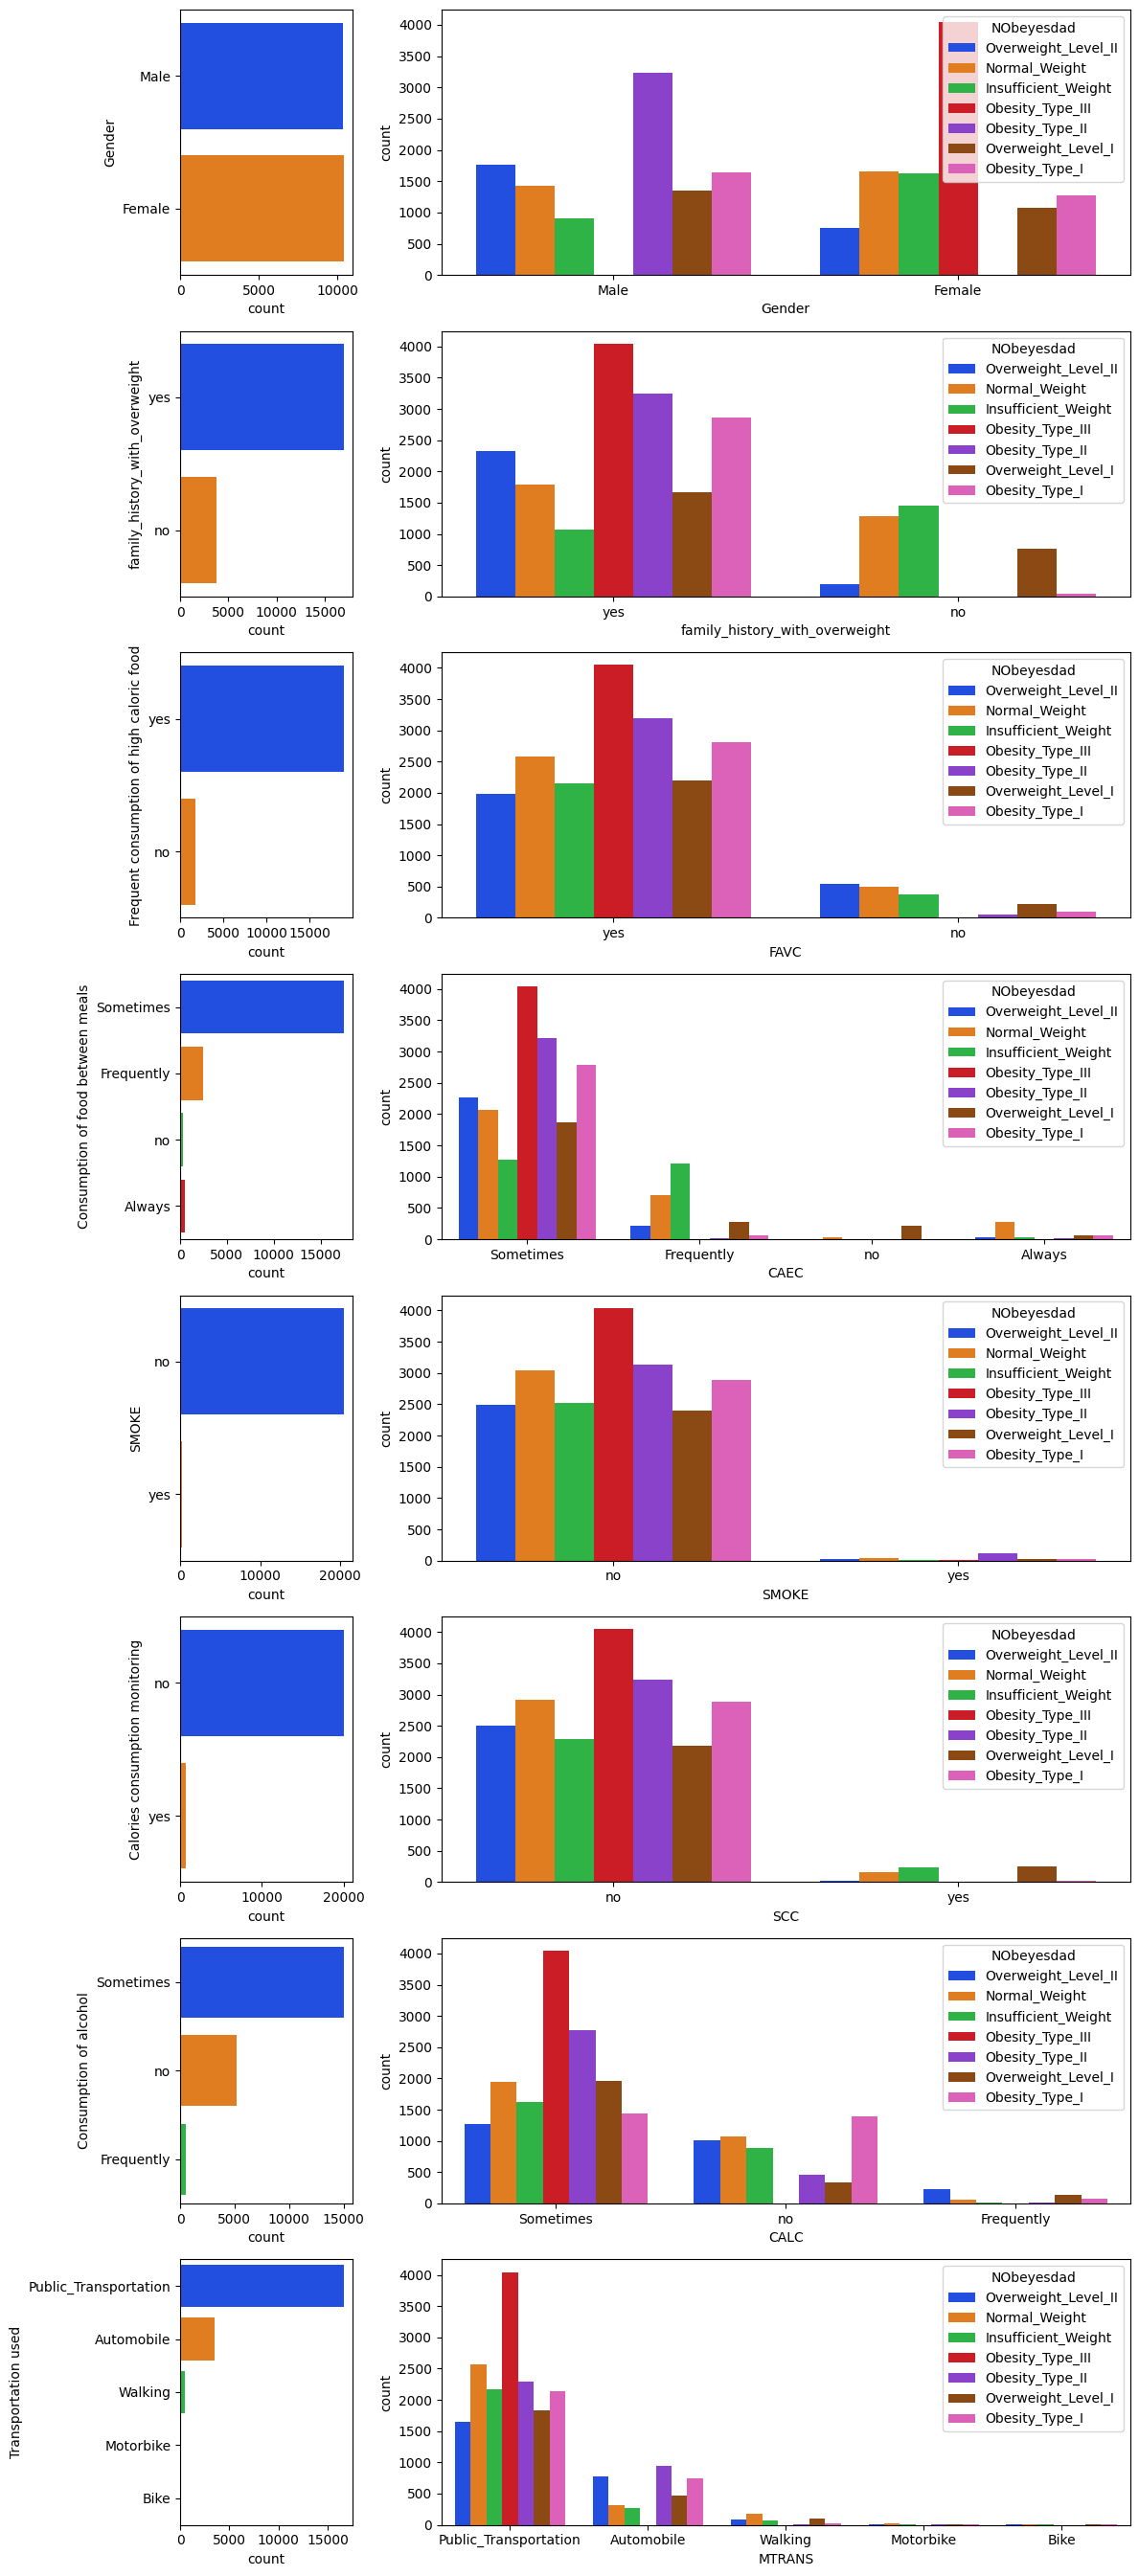

In [11]:
_,axs = plt.subplots(int(len(raw_cat_cols)-1),2,figsize=(12,len(raw_cat_cols)*3),width_ratios=[1, 4])
for i,col in enumerate(raw_cat_cols[1:]):
    sns.countplot(y=col,data=train,palette="bright",ax=axs[i,0])
    sns.countplot(x=col,data=train,hue=TARGET,palette="bright",ax=axs[i,1])
    if col in full_form.keys():
        axs[i,0].set_ylabel(full_form[col])


plt.tight_layout()
plt.show()


In [ ]:
tmp = train[raw_num_cols].corr("pearson")
sns.heatmap(tmp,annot=True,cmap ="crest")

In [ ]:
sns.jointplot(data=train, x="Height", y="Weight", hue=TARGET,height=6)

In [ ]:
sns.jointplot(data=train, x="Age", y="Height", hue=TARGET,height=6)

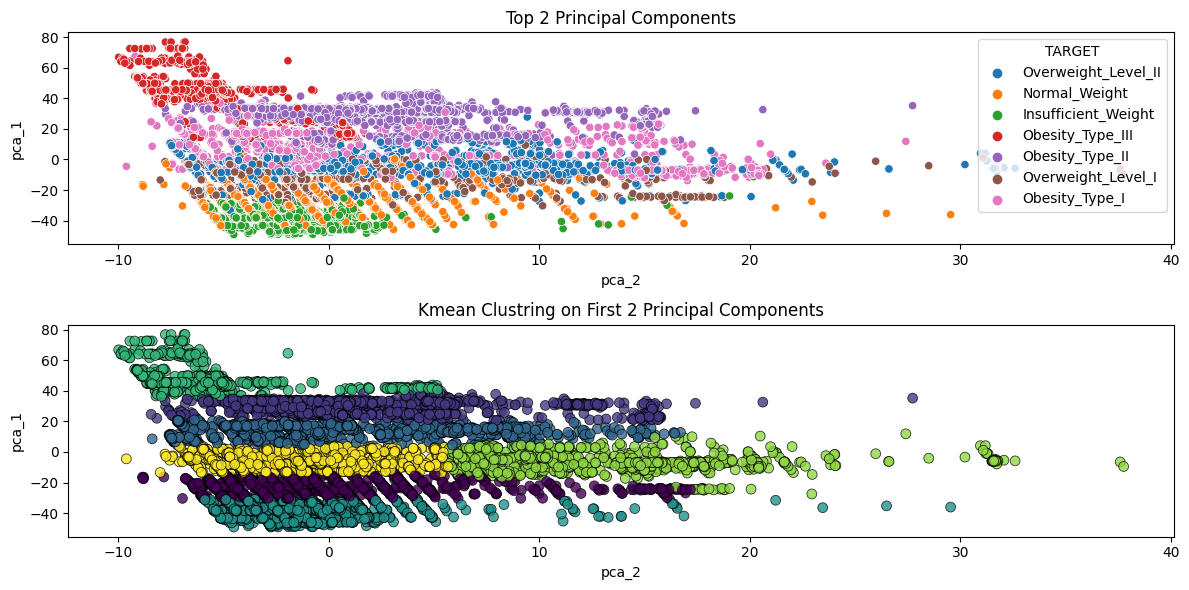

In [15]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=2)
pca_top_2 = pca.fit_transform(train[raw_num_cols])

tmp = pd.DataFrame(data = pca_top_2, columns = ['pca_1','pca_2'])
tmp['TARGET'] = train[TARGET]

fig,axs = plt.subplots(2,1,figsize = (12,6))
sns.scatterplot(data=tmp, y="pca_1", x="pca_2", hue='TARGET',ax=axs[0])
axs[0].set_title("Top 2 Principal Components")

kmeans = KMeans(7,random_state=RANDOM_SEED)
kmeans.fit(tmp[['pca_1','pca_2']])
sns.scatterplot( y= tmp['pca_1'],x = tmp['pca_2'],c = kmeans.labels_,cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.8,ax = axs[1])
axs[1].set_title("Kmean Clustring on First 2 Principal Components")
plt.tight_layout()
plt.show()

In [16]:
def age_rounder(x):
    x_copy = x.copy()
    x_copy['Age'] = (x_copy['Age']*100).astype(np.uint16)
    return x_copy

def height_rounder(x):
    x_copy = x.copy()
    x_copy['Height'] = (x_copy['Height']*100).astype(np.uint16)
    return x_copy

def extract_features(x):
    x_copy = x.copy()
    x_copy['BMI'] = (x_copy['Weight']/x_copy['Height']**2)   
    return x_copy

def col_rounder(x):
    x_copy = x.copy()
    cols_to_round = ['FCVC',"NCP","CH2O","FAF","TUE"]
    for col in cols_to_round:
        x_copy[col] = round(x_copy[col])
        x_copy[col] = x_copy[col].astype('int')
    return x_copy

AgeRounder = FunctionTransformer(age_rounder)
HeightRounder = FunctionTransformer(height_rounder)
ExtractFeatures = FunctionTransformer(extract_features)
ColumnRounder = FunctionTransformer(col_rounder)

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self,x,y):
        return self
    def transform(self, x):
        return x.drop(self.cols, axis = 1)

In [18]:
target_mapping = {
                  'Insufficient_Weight':0,
                  'Normal_Weight':1,
                  'Overweight_Level_I':2,
                  'Overweight_Level_II':3, 
                  'Obesity_Type_I':4,
                  'Obesity_Type_II':5 ,
                  'Obesity_Type_III':6
                  }

skf = StratifiedKFold(n_splits=n_splits)

def cross_val_model(estimators,cv = skf, verbose = True):
    '''
        estimators : pipeline consists preprocessing, encoder & model
        cv : Method for cross validation (default: StratifiedKfold)
        verbose : print train/valid score (yes/no)
    '''
    
    X = train.copy()
    y = X.pop(TARGET)

    y = y.map(target_mapping)
    test_predictions = np.zeros((len(test),7))
    valid_predictions = np.zeros((len(X),7))

    val_scores, train_scores = [],[]
    for fold, (train_ind, valid_ind) in enumerate(skf.split(X,y)):
        model = clone(estimators)

        X_train = X.iloc[train_ind]
        y_train = y.iloc[train_ind]

        X_valid = X.iloc[valid_ind]
        y_valid = y.iloc[valid_ind]

        model.fit(X_train, y_train)
        if verbose:
            print("-" * 100)
            print(f"Fold: {fold}")
            print(f"Train Accuracy Score:-{accuracy_score(y_true=y_train,y_pred=model.predict(X_train))}")
            print(f"Valid Accuracy Score:-{accuracy_score(y_true=y_valid,y_pred=model.predict(X_valid))}")
            print("-" * 100)

        
        test_predictions += model.predict_proba(test)/cv.get_n_splits()
        valid_predictions[valid_ind] = model.predict_proba(X_valid)
        val_scores.append(accuracy_score(y_true=y_valid,y_pred=model.predict(X_valid)))
    if verbose: 
        print(f"Average Mean Accuracy Score:- {np.array(val_scores).mean()}")
    return val_scores, valid_predictions, test_predictions

In [19]:
train.drop(['id'],axis = 1, inplace = True)
test_ids = test['id']
test.drop(['id'],axis = 1, inplace=True)

train = pd.concat([train,train_org],axis = 0)
train = train.drop_duplicates()
train.reset_index(drop=True, inplace=True)

In [20]:
score_list, oof_list, predict_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

<a id = "rfC"> </a>
# Random Forest Model

In [21]:
RFC = make_pipeline(
                        ExtractFeatures,
                        MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS']),
                       RandomForestClassifier(random_state=RANDOM_SEED)
                    )

In [22]:
val_scores,val_predictions,test_predictions = cross_val_model(RFC)

for k,v in target_mapping.items():
    oof_list[f"rfc_{k}"] = val_predictions[:,v]

for k,v in target_mapping.items():
    predict_list[f"rfc_{k}"] = test_predictions[:,v]

----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-0.9999015069437605
Valid Accuracy Score:-0.8972036234738086
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-1.0
Valid Accuracy Score:-0.8928712091374557
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-0.9999015069437605
Valid Accuracy Score:-0.8940527766837337
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy Score:-0.999901

<a id = "lgbm"></a>
# LGBM Model

In [ ]:
def lgbm_objective(trial):
    params = {
        'learning_rate' : trial.suggest_float('learning_rate', .001, .1, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 20),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'min_child_weight' : trial.suggest_float('min_child_weight', .1, 15, log = True),
        'reg_lambda' : trial.suggest_float('reg_lambda', .1, 20, log = True),
        'reg_alpha' : trial.suggest_float('reg_alpha', .1, 10, log = True),
        'n_estimators' : 1000,
        'random_state' : RANDOM_SEED,
        'device_type' : "gpu",
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
    }
    
    optuna_model = make_pipeline(
                                 ExtractFeatures,
                                 MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS']),
                                LGBMClassifier(**params,verbose=-1)
                                )
    val_scores, _, _ = cross_val_model(optuna_model,verbose = False)
    return np.array(val_scores).mean()

lgbm_study = optuna.create_study(direction = 'maximize',study_name="LGBM")

In [25]:
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = train.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('NObeyesdad')

In [26]:
params = {'learning_rate': 0.04325905707439143, 'max_depth': 4, 
          'subsample': 0.6115083405793659, 'min_child_weight': 0.43633356137010687, 
          'reg_lambda': 9.231766981717822, 'reg_alpha': 1.875987414096491, 'num_leaves': 373,
          'n_estimators' : 1000,'random_state' : RANDOM_SEED, 'device_type' : "gpu",
         }

best_params = {
    "objective": "multiclass",          
    "metric": "multi_logloss",          
    "verbosity": -1,                    
    "boosting_type": "gbdt",            
    "random_state": 42,      
    "num_class": 7,                 
    'learning_rate': 0.030962211546832760,  
    'n_estimators': 500,               
    'lambda_l1': 0.009667446568254372,  
    'lambda_l2': 0.04018641437301800,   
    'max_depth': 10,                    
    'colsample_bytree': 0.40977129346872643,  
    'subsample': 0.9535797422450176,    
    'min_child_samples': 26           
}

lgbm = make_pipeline(    
                        ColumnTransformer(
                        transformers=[('num', StandardScaler(), numerical_columns),
                                  ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_columns)]),
                        LGBMClassifier(**best_params,verbose=-1)
                    )

In [27]:
val_scores,val_predictions,test_predictions = cross_val_model(lgbm)

for k,v in target_mapping.items():
    oof_list[f"lgbm_{k}"] = val_predictions[:,v]
    
for k,v in target_mapping.items():
    predict_list[f"lgbm_{k}"] = test_predictions[:,v]

----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-0.9784792672116616
Valid Accuracy Score:-0.9070500196927924
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-0.9777898158179849
Valid Accuracy Score:-0.9086254430878299
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-0.9788732394366197
Valid Accuracy Score:-0.9031114612051989
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy 

<a id = "xgb"></a>
# XGB Model

In [ ]:
def xgb_objective(trial):
    params = {
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'gamma' : trial.suggest_float('gamma', 1e-9, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 0, 24),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
    }

    params['booster'] = 'gbtree'
    params['objective'] = 'multi:softmax'
    params["device"] = "cuda"
    params["verbosity"] = 0
    params['tree_method'] = "gpu_hist"
    
    
    optuna_model = make_pipeline(
                    MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS']),
                    XGBClassifier(**params,seed=RANDOM_SEED)
                   )
    
    val_scores, _, _ = cross_val_model(optuna_model,verbose = False)
    return np.array(val_scores).mean()

xgb_study = optuna.create_study(direction = 'maximize')

In [29]:
TUNE = False
if TUNE:
    xgb_study.optimize(xgb_objective, 50)

In [30]:
params = {
    'n_estimators': 1312,
    'learning_rate': 0.018279520260162645,
    'gamma': 0.0024196354156454324,
    'reg_alpha': 0.9025931173755949,
    'reg_lambda': 0.06835667255875388,
    'max_depth': 5,
    'min_child_weight': 5,
    'subsample': 0.883274050086088,
    'colsample_bytree': 0.6579828557036317
}

params = {'grow_policy': 'depthwise', 'n_estimators': 690, 
               'learning_rate': 0.31829021594473056, 'gamma': 0.6061120644431842, 
               'subsample': 0.9032243794829076, 'colsample_bytree': 0.44474031945048287,
               'max_depth': 10, 'min_child_weight': 22, 'reg_lambda': 4.42638097284094,
               'reg_alpha': 5.927900973354344e-07,'seed':RANDOM_SEED}

best_params = {'grow_policy': 'depthwise', 'n_estimators': 982, 
               'learning_rate': 0.050053726931263504, 'gamma': 0.5354391952653927, 
               'subsample': 0.7060590452456204, 'colsample_bytree': 0.37939433412123275, 
               'max_depth': 23, 'min_child_weight': 21, 'reg_lambda': 9.150224029846654e-08,
               'reg_alpha': 5.671063656994295e-08}
best_params['booster'] = 'gbtree'
best_params['objective'] = 'multi:softmax'
best_params["device"] = "cuda"
best_params["verbosity"] = 0
best_params['tree_method'] = "gpu_hist"
    
XGB = make_pipeline(
                    MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS']),
                    XGBClassifier(**best_params,seed=RANDOM_SEED)
                   )

In [31]:
val_scores,val_predictions,test_predictions = cross_val_model(XGB)

for k,v in target_mapping .items():
    oof_list[f"xgb_{k}"] = val_predictions[:,v]

for k,v in target_mapping.items():
    predict_list[f"xgb_{k}"] = test_predictions[:,v]

----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-0.9439082044715847
Valid Accuracy Score:-0.9086254430878299
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-0.9445484093371417
Valid Accuracy Score:-0.9082315872390705
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-0.944696148921501
Valid Accuracy Score:-0.9054745962977551
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy S

<a id = "cat"></a>
# Catboost Model


In [ ]:
def cat_objective(trial):
    
    params = {
        
        'iterations': 1000, 
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_seed': RANDOM_SEED,
        'verbose': False,
        'task_type':"GPU"
    }
    
    cat_features = ['Gender','family_history_with_overweight','FAVC','FCVC','NCP',
                'CAEC','SMOKE','CH2O','SCC','FAF','TUE','CALC','MTRANS']
    optuna_model = make_pipeline(
                        ExtractFeatures,
                        CatBoostClassifier(**params,cat_features=cat_features)
                        )
    val_scores,_,_ = cross_val_model(optuna_model,verbose = False)
    return np.array(val_scores).mean()
    
cat_study = optuna.create_study(direction = 'maximize')

In [33]:
params = {'learning_rate': 0.13762007048684638, 'depth': 5, 
          'l2_leaf_reg': 5.285199432056192, 'bagging_temperature': 0.6029582154263095,
         'random_seed': RANDOM_SEED,
        'verbose': False,
        'task_type':"GPU",
         'iterations':1000}


CB = make_pipeline(
                        CatBoostClassifier(**params, cat_features=categorical_columns)
                        )

In [34]:
val_scores,val_predictions,test_predictions = cross_val_model(CB)
for k,v in target_mapping.items():
    oof_list[f"cat_{k}"] = val_predictions[:,v]

for k,v in target_mapping.items():
    predict_list[f"cat_{k}"] = test_predictions[:,v]

----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-0.9504579927115139
Valid Accuracy Score:-0.9035053170539582
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-0.9511474441051906
Valid Accuracy Score:-0.9050807404489957
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-0.9492268295085197
Valid Accuracy Score:-0.9011421819614022
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy 

# Model Evaluation

In [ ]:
weights = {"rfc_":0,
           "lgbm_":3,
           "xgb_":1,
           "cat_":0}
tmp = oof_list.copy()
for k,v in target_mapping.items():
    tmp[f"{k}"] = (weights['rfc_']*tmp[f"rfc_{k}"] +
              weights['lgbm_']*tmp[f"lgbm_{k}"]+
              weights['xgb_']*tmp[f"xgb_{k}"]+
              weights['cat_']*tmp[f"cat_{k}"])    
tmp['pred'] = tmp[target_mapping.keys()].idxmax(axis = 1)
tmp['label'] = train[TARGET]
print(f"Ensemble Accuracy Scoe: {accuracy_score(train[TARGET],tmp['pred'])}")
    
cm = confusion_matrix(y_true = tmp['label'].map(target_mapping),
                      y_pred = tmp['pred'].map(target_mapping),
                     normalize='true')

cm = cm.round(2)
plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = target_mapping.keys())
disp.plot(xticks_rotation=50)
plt.tight_layout()
plt.show()